```python

import wget

!python -m wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv -o data.csv
    
```    

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


***

&nbsp;

&nbsp;

# Preparation

- Create the target variable by mapping yes to 1 and no to 0.

- Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution.  Use `train_test_split` funciton for that with `random_state=1`.

In [4]:
df['target'] = df['card'].apply(lambda x: 1 if x == "yes" else 0).astype(int)

In [5]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,target
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12,1
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13,1
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5,1
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7,1
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5,1


In [6]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

del df_train['target']
del df_val['target']
del df_test['target']

***

&nbsp;

&nbsp;

# Question 1

**ROC AUC could also be used to evaluate feature importance of numerical variables.**


Let's do that

- For each numerical variable, use it as score and compute AUC with the card variable.
- Use the training dataset for that. If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)


- AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- **reports**
- dependents
- active
- share

In [7]:
numerical = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "active"]

categorical = ["card" ,"owner" ,"selftemp" ,"majorcards" ,"target"]

In [8]:
from sklearn.metrics import roc_auc_score

for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

  reports, 0.712
      age, 0.514
   income, 0.590
    share, 0.990
expenditure, 0.992
dependents, 0.529
   months, 0.523
   active, 0.610


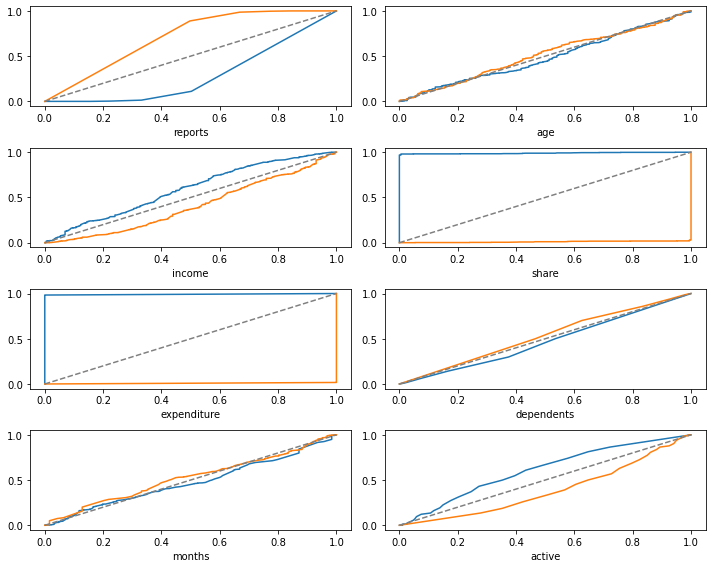

In [9]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

a = 4  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(10,8))

for i in numerical:
    plt.subplot(a, b, c)
    plt.title(''.format(i, a, b, c)) #{}, subplot: {},{},{}
    plt.xlabel(i)
    fpr, tpr, _ = roc_curve(y_train, df_train[i])
    plt.plot(fpr, tpr, label=f'+{[i]}')
    fpr, tpr, _ = roc_curve(y_train, -df_train[i])
    plt.plot(fpr, tpr, label=f'-{[i]}')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    c = c + 1

plt.tight_layout()
plt.show()

***

&nbsp;

&nbsp;

# Training the model

From now on, use these columns only:

`["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]`

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

In [10]:
cols_to_keep = ["reports", "age", "income", 
                "share", "expenditure", "dependents", 
                "months", "majorcards", "active", 
                "owner", "selfemp"]

df_train = df_train[cols_to_keep]
df_val = df_val[cols_to_keep]
df_test = df_test[cols_to_keep]

In [11]:
numerical = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "active"]
categorical = ["owner" ,"selfemp" ,"majorcards"]

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

***

&nbsp;

&nbsp;

# Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- **0.995**

In [12]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
decision = (y_pred >= 0.5)
(y_val == decision).mean()

0.9620853080568721

In [13]:
roc_auc_score(y_val, y_pred)

0.9941860465116279

In [14]:
y_pred_bin = model.predict(X_val)
roc_auc_score(y_val, y_pred_bin)

0.9675387596899225

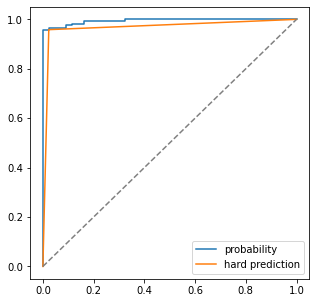

In [15]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

***

&nbsp;

&nbsp;

# Question 3

Now let's compute precision and recall for our model.

1. Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
2. For each threshold, compute precision and recall
3. Plot them

At which threshold precision and recall curves intersect?

- **0.1**
- 0.3
- 0.6
- 0.8

In [16]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [17]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

In [18]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,168,43,0,0
10,0.1,167,13,1,30
20,0.2,164,4,4,39
30,0.3,162,4,6,39
40,0.4,161,1,7,42
50,0.5,161,1,7,42
60,0.6,161,1,7,42
70,0.7,161,1,7,42
80,0.8,161,1,7,42
90,0.9,161,0,7,43


In [19]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [20]:
intersect = df_scores.loc[df_scores['p'] == df_scores['r']]

In [21]:
intersect

,threshold,tp,fp,fn,tn,p,r
18,0.18,164,4,4,39,0.97619,0.97619
19,0.19,164,4,4,39,0.97619,0.97619
20,0.20,164,4,4,39,0.97619,0.97619
21,0.21,164,4,4,39,0.97619,0.97619
22,0.22,164,4,4,39,0.97619,0.97619
23,0.23,164,4,4,39,0.97619,0.97619


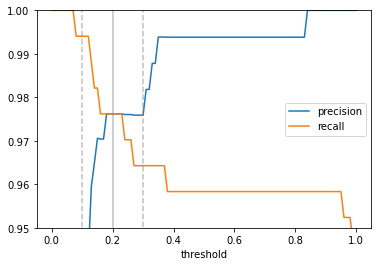

In [22]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

# At which threshold precision and recall curves intersect?
# Options 0.1, 0.3, 0.6, 0.8. 

plt.vlines(0.1, 0, 1, color='grey', linestyle='--', alpha=0.5)
plt.vlines(0.2, 0, 1, color='grey', linestyle='-', alpha=0.5)
plt.vlines(0.3, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.ylim(0.95, 1.0)
plt.xlabel("threshold")

plt.legend()
plt.show()

***

&nbsp;

&nbsp;

# Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_{1} = 2 \cdot \frac{P \cdot R}{(P + R)}$$

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- **0.4**
- 0.6
- 0.7

In [23]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [24]:
df2 = df_scores.loc[df_scores['f1'].idxmax()] #Find values in df_score associated to maximum f1
df2

threshold      0.350000
tp           162.000000
fp             1.000000
fn             6.000000
tn            42.000000
p              0.993865
r              0.964286
f1             0.978852
Name: 35, dtype: float64

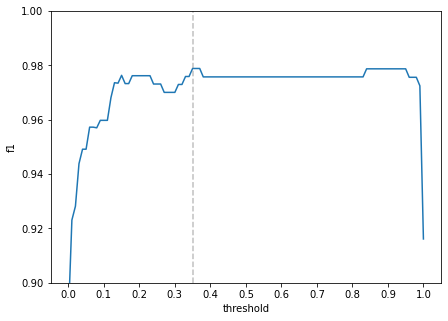

In [25]:
plt.figure(figsize=(7, 5))

plt.plot(df_scores.threshold, df_scores.f1)

plt.vlines(0.35, 0.9, 1.0, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.ylim(0.90, 1.0)
plt.xlabel("threshold")
plt.ylabel("f1")
plt.show()

***

&nbsp;

&nbsp;

# Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`

1. Iterate over different folds of `df_full_train`
2. Split the data into train and validation
3. Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
4. Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

- **0.003**
- 0.014
- 0.09
- 0.24

In [31]:
from sklearn.model_selection import KFold

def train(df_train, y_train, C=1.0):
    dicts = df_train[cols_to_keep].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[cols_to_keep].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [32]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.target.values
    y_val = df_val.target.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


Standard devidation of the AUC scores across different folds?
**0.003**

***

&nbsp;

&nbsp;

# Question 6

Now let's use 5-Fold cross-validation to find the best parameter C:

1. Iterate over the following `C` values: `[0.01, 0.1, 1, 10]`
2. Initialize KFold with the same parameters as previously
3. Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
4. Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- **0.01**
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, **select the smallest C**

In [35]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.target.values
        y_val = df_val.target.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.6f +- %.6f' % (C, np.mean(scores), np.std(scores)))
    
# If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

C=0.01, 0.996450 +- 0.002743
C= 0.1, 0.996450 +- 0.002743
C=   1, 0.996450 +- 0.002743
C=  10, 0.996450 +- 0.002743
